# Japan Deflation Analysis

In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# visualization
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

sns.set(color_codes=True)

In [3]:
def transform_dataset(data):
    data = data.set_index('Unnamed: 0')
    data.index.rename('', inplace=True)
    return data

In [4]:
# import relevant dataset
full_data = pd.read_csv('data/full_data.csv')
economic_index = pd.read_csv('data/ei_combined.csv')
cpi_index = pd.read_csv('data/cpi_index.csv')
gdp_production_index = pd.read_csv('data/gdp_production_index.csv')
health_index = pd.read_csv('data/health_index.csv')
population_index = pd.read_csv('data/population_index.csv')
ppp_index = pd.read_csv('data/ppp_index.csv')
productivity_ulc_index = pd.read_csv('data/productivity_ulc_index.csv')

# transform relevant dataset
full_data = transform_dataset(full_data)
economic_index = transform_dataset(economic_index)
cpi_index = transform_dataset(cpi_index)
gdp_production_index = transform_dataset(gdp_production_index)
health_index = transform_dataset(health_index)
population_index = transform_dataset(population_index)
ppp_index = transform_dataset(ppp_index)
productivity_ulc_index = transform_dataset(productivity_ulc_index)

population_index = population_index.drop(columns=['89'])

## Introduction

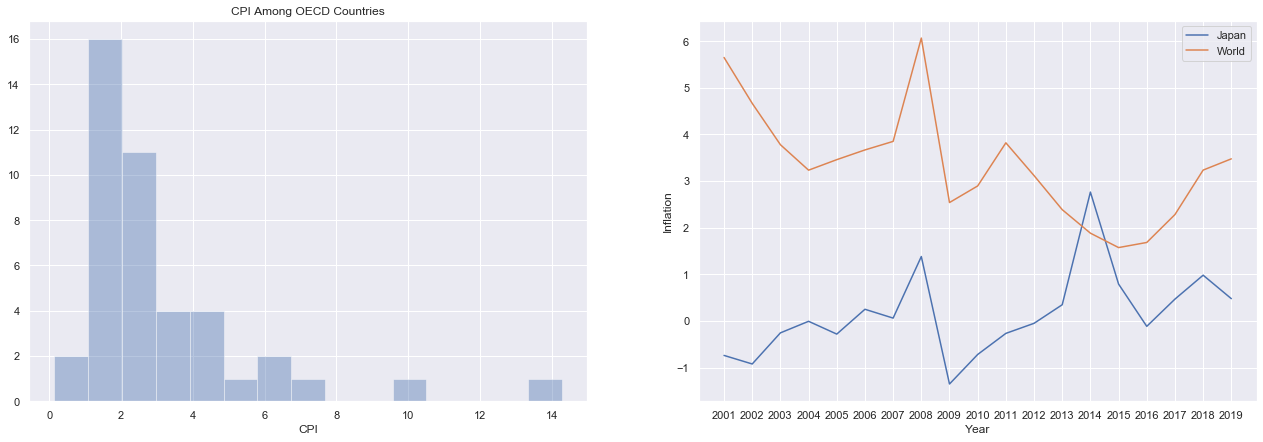

In [5]:
# import data
cpi_history = pd.read_csv('data/cpi.csv')
oecd_cpi = cpi_index['CPI: 01-12 - All items']

# select data
cpi_history = cpi_history.loc[cpi_history['Subject'] == 'CPI: 01-12 - All items'][['Country', 'Time', 'Value']]
cpi_japan = cpi_history.loc[cpi_history['Country'] == 'Japan']
cpi_world = cpi_history.loc[cpi_history['Country'] != 'Japan']

# create data
time_series = cpi_world['Time'].unique()
avg_cpi = []

for time in time_series:
    avg_cpi.append(cpi_world.loc[cpi_world['Time'] == time]['Value'].mean())
    
# plot graph
plt.figure(figsize = (22, 7))

plt.subplot(1, 2, 1)
sns.distplot(oecd_cpi.values, kde=False)
plt.xlabel('CPI')
plt.title('CPI Among OECD Countries')

plt.subplot(1, 2, 2)
plt.plot(cpi_japan['Time'], cpi_japan['Value'], label="Japan")
plt.plot(cpi_japan['Time'], avg_cpi, label="World")
plt.xticks(range(2001, 2020, 1))
plt.xlabel('Year')
plt.ylabel('Inflation')
plt.legend()
plt.show()

## Comparing Social Factors

In [6]:
country_list = cpi_index.index
cpi = cpi_index['CPI: 01-12 - All items'].values
cpi_dict = list(zip(country_list, cpi))

cpi_good = []
for cpi in cpi_dict:
    if cpi[1] >= 2 and cpi[1] <= 3:
        cpi_good.append(cpi)
        
cpi_series = pd.DataFrame({'CPI': [cpi[1] for cpi in cpi_good]}, index=[cpi[0] for cpi in cpi_good])
cpi_series = cpi_series.sort_values(by=['CPI'], ascending=False)
cpi_series

,CPI
Slovenia,2.759940
Australia,2.544193
Lithuania,2.508400
Korea,2.426587
China (People's Republic of),2.326316
Czech Republic,2.156178
Poland,2.154386
United States,2.106992
New Zealand,2.103123
United Kingdom,2.057895


In [7]:
def get_inflation_countries(data):
    relevant_data =  data.loc[
        (data.index == 'Slovenia') |
        (data.index == 'Australia') |
        (data.index == 'Lithuania')|
        (data.index == 'Korea') |
        (data.index == 'China (People\'s Republic of)') |
        (data.index == 'Czech Republic') |
        (data.index == 'Poland') |
        (data.index == 'United States') |
        (data.index == 'New Zealand') |
        (data.index == 'United Kingdom') |
        (data.index == 'Norway') |
        (data.index == 'Spain') |
        (data.index == 'Japan')
    ]
    
    return relevant_data.sort_index()

In [8]:
ei_inflation = get_inflation_countries(economic_index.dropna(axis='columns'))
cpi_inflation = get_inflation_countries(cpi_index.dropna(axis='columns'))
gdp_production_inflation = get_inflation_countries(gdp_production_index.dropna(axis='columns'))
health_inflation = get_inflation_countries(health_index.dropna(axis='columns'))
population_inflation = get_inflation_countries(population_index.dropna(axis='columns'))
ppp_inflation = get_inflation_countries(ppp_index.dropna(axis='columns'))
productivity_inflation = get_inflation_countries(productivity_ulc_index.dropna(axis='columns'))

In [9]:
def create_standarized_dataset(data):
    """
    """
    # create pipeline
    data_copy = data.copy()
    
    if len(data.columns) > 1:
        num_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy="mean")),
            ('std_scaler', StandardScaler())
        ])
        transformed_data = num_pipeline.fit_transform(data_copy)
    else:
        transformed_data = StandardScaler().fit_transform(data)
    
    data_copy[:] = transformed_data
    return data_copy

In [10]:
# exclude purchasing power parity, cpi, and health as only one column
ei_standarized = create_standarized_dataset(ei_inflation)
gdp_production_standarized = create_standarized_dataset(gdp_production_inflation)
population_standarized = create_standarized_dataset(population_inflation)
productivity_standarized = create_standarized_dataset(productivity_inflation)
health_standarized = create_standarized_dataset(health_inflation)
ppp_standarized = create_standarized_dataset(ppp_inflation)

In [11]:
pca = PCA(n_components=2)

ei_reduced = pca.fit_transform(ei_standarized)
gdp_production_reduced = pca.fit_transform(gdp_production_standarized)
population_reduced = pca.fit_transform(population_inflation)
productivity_reduced = pca.fit_transform(productivity_standarized)

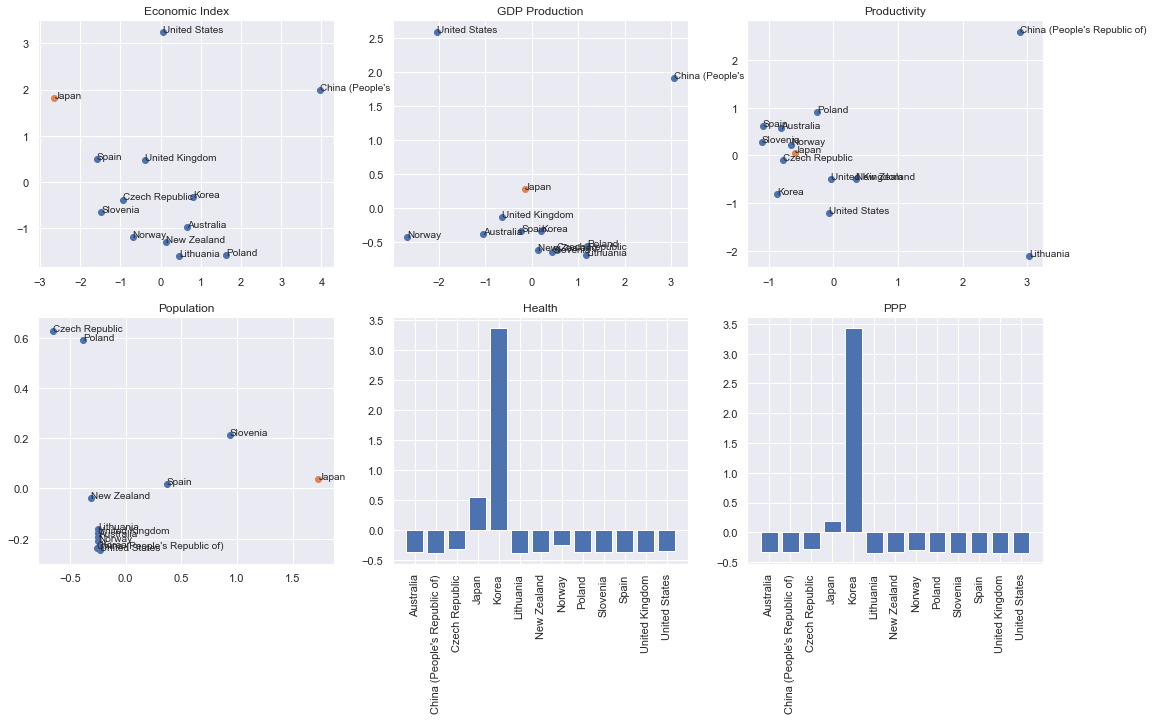

In [12]:
plt.figure(figsize=(18, 10))

index = 1
reduced_data = [("Economic Index", ei_reduced), ("GDP Production", gdp_production_reduced), 
                ("Productivity", productivity_reduced), ("Population", population_reduced), ("Health", health_standarized),
               ("PPP", ppp_standarized)]

for title, data in reduced_data:
    plt.subplot(2, 3, index)
    
    if isinstance(data, pd.DataFrame):
        plt.title(title)
        plt.xticks(rotation=90)
        plt.bar([x for x in data.index], np.ndarray.flatten(data.values))
    else:
        japan = data[3]
        others = np.delete(data, 3, 0)

        plt.scatter(others[:, 0], others[:, 1])
        plt.scatter(japan[0], japan[1])

        country_data = [x for x in ei_inflation.index if x != 'Japan']
        for i, txt in enumerate(country_data):
            plt.annotate(txt, (others[:, 0][i], others[:, 1][i]))
        plt.annotate("Japan", (japan[0], japan[1]))
        plt.title(title)
    
    index += 1
plt.show()

## Looking into Social Factors

### Economic Index

In [13]:
ei_inflation

,"Exports in goods, s.a.","Imports in goods, s.a.",Share prices,Consumer prices: all items,"Gross domestic product; constant prices, s.a.",Overnight interbank rate,"Current account as a % of GDP, s.a."
,,,,,,,
Australia,65.066161,62.010703,4.435165,31.276290,2.846152,3.706842,-3.954578
China (People's Republic of),516.261858,435.157550,7.711203,30.965639,9.172153,3.067895,3.539535
Czech Republic,50.526682,46.654352,5.720108,32.023710,2.786704,1.544737,-1.939866
Japan,219.260484,214.209076,2.033844,32.824824,0.804440,0.070305,2.969035
Korea,144.481164,132.210814,6.875917,31.425293,3.853836,2.846316,3.056706
Lithuania,16.718985,16.775606,15.079314,31.495382,4.169892,1.373325,-3.171408
New Zealand,14.263578,15.094824,5.327814,31.740922,2.883612,3.924211,-3.701504
Norway,41.554862,27.571758,11.007439,32.040802,1.598191,2.647895,11.027120
Poland,60.829151,63.049286,8.414118,31.065411,3.791841,4.434211,-3.014520


- Gross domestic product (constant prices)
    - Real gross domestic product is a macroeconomic statistic that measures the value of the goods and services produced by an economy in a specific period, adjusted for inflation
    - Japan shows little growth with an average of 0.8
- Overnight interbank rate
    - The overnight rate is the interest rate at which a depository institution (generally banks) lends or borrows funds with another depository institution in the overnight market. In many countries, the overnight rate is the interest rate the central bank sets to target monetary policy.
    - Japan's overnight interbank rate is much smaller compared to the other countries.

In [14]:
gdp_production_inflation

,Gross Domestic Product (GDP); millions,GDP per head of population,GDP per person employed
,,,
Australia,9.495379e+05,42361.716217,82876.488548
China (People's Republic of),1.367807e+07,10059.324015,17852.530240
Czech Republic,2.983312e+05,28508.055581,58144.373383
Japan,4.515240e+06,35448.689094,68223.444759
Korea,1.574108e+06,31532.284260,63686.265288
Lithuania,6.753784e+04,22315.196059,49887.903082
New Zealand,1.431837e+05,32243.940811,64090.023236
Norway,2.785042e+05,56242.856037,108003.587378
Poland,8.028952e+05,20920.863079,51960.398046


### Population

Download new data

In [26]:
population_data = pd.read_csv('data/population_total.csv')
population_data = population_data.drop(columns=['LOCATION', 'SEX', 'Sex', 'AGE', 'TIME', 'Flag Codes', 'Flags'])
population_data.head()

,Country,Age,Time,Value
0,Australia,Total,2001,19274701.0
1,Australia,Total,2002,19495210.0
2,Australia,Total,2003,19720737.0
3,Australia,Total,2004,19932722.0
4,Australia,Total,2005,20176844.0


In [30]:
total_population = population_data.loc[population_data['Age'] == 'Total']
over_65 = population_data.loc[population_data['Age'] == 'Share of 65 and over - elderly']
from_15_64 = population_data.loc[population_data['Age'] == 'Share of 15 to 64 - working age']
under_15 = population_data.loc[population_data['Age'] == 'Share of under 15 - children']

In [47]:
def get_dict_data(data):
    """
    """
    country_list = population_data['Country'].unique()
    data_arr = []
    
    for country in country_list:
        data_country = data.loc[data['Country'] == country][['Time', 'Value']].values
        data_arr.append(data_country)
        
    population_dict = dict(zip(country_list, data_arr))
    return population_dict

In [48]:
population_countries = get_dict_data(total_population)
over_65_countries = get_dict_data(over_65)
from_15_64_countries = get_dict_data(from_15_64)
under_15_countries = get_dict_data(under_15)

In [62]:
def plot_population_graph(data):
    for key in data:
        plt.plot(data[key][:, 0], data[key][:, 1], label=key)
        plt.xticks(range(2001, 2019, 5))
        plt.legend()
        plt.xlabel('Year')

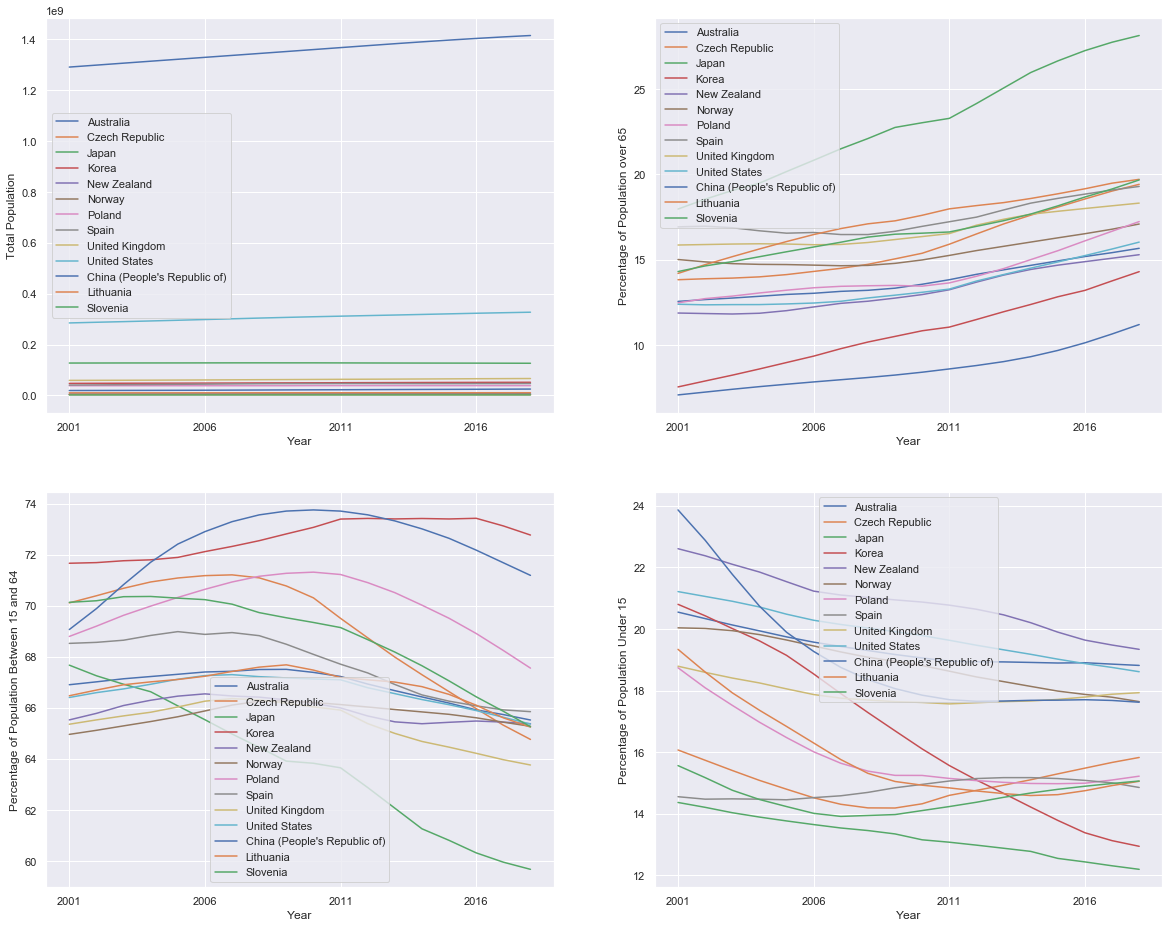

In [69]:
plt.figure(figsize=(20, 16))

plt.subplot(2, 2, 1)
plot_population_graph(population_countries)
plt.ylabel('Total Population')

plt.subplot(2, 2, 2)
plot_population_graph(over_65_countries)
plt.ylabel('Percentage of Population over 65')

plt.subplot(2, 2, 3)
plot_population_graph(from_15_64_countries)
plt.ylabel('Percentage of Population Between 15 and 64')

plt.subplot(2, 2, 4)
plot_population_graph(under_15_countries)
plt.ylabel('Percentage of Population Under 15')

plt.show()